In [6]:
import torch
from utils import *
from collections import defaultdict
import matplotlib.pyplot as plt
import time

from models.rendering import *
from models.nerf import *

import metrics

from datasets import dataset_dict
from datasets.llff import *

torch.backends.cudnn.benchmark = True

img_wh = (200, 200)


dataset = dataset_dict['blender'] \
          ('./data/nerf_synthetic/cup_s8/', 'test',
           img_wh=img_wh)

In [7]:
hand_embedding_xyz = Embedding(3, 10)
hand_embedding_dir = Embedding(3, 4)
object_embedding_xyz = Embedding(3, 10)
object_embedding_dir = Embedding(3, 4)

hand_nerf_coarse = NeRF()
hand_nerf_fine = NeRF()
object_nerf_coarse = NeRF()
object_nerf_fine = NeRF()

hand_ckpt_path = './ckpts/hand_flat_same/epoch=7.ckpt'
object_ckpt_path = './ckpts/cup_s8/epoch=7.ckpt'



load_ckpt(hand_nerf_coarse, hand_ckpt_path, model_name='nerf_coarse')
load_ckpt(hand_nerf_fine, hand_ckpt_path, model_name='nerf_fine')
load_ckpt(object_nerf_coarse, object_ckpt_path, model_name='nerf_coarse')
load_ckpt(object_nerf_fine, object_ckpt_path, model_name='nerf_fine')

hand_nerf_coarse.cuda().eval()
hand_nerf_fine.cuda().eval()
object_nerf_coarse.cuda().eval()
object_nerf_fine.cuda().eval();

In [8]:
from models.render_blend_mesh import render_rays_blend
hand_models = [hand_nerf_coarse, hand_nerf_fine]
hand_embeddings = [hand_embedding_xyz, hand_embedding_dir]
object_models = [object_nerf_coarse, object_nerf_fine]
object_embeddings = [object_embedding_xyz, object_embedding_dir]

N_samples = 64
N_importance = 64
use_disp = False
chunk = 1024*32*4

@torch.no_grad()
def f_trans(rays, poses = None, mano_layer = None, global_translation = None):
    """Do batched inference on rays using chunk."""
    B = rays.shape[0]
    results = defaultdict(list)
    for i in range(0, B, chunk):
        rendered_ray_chunks = \
            render_rays_blend(hand_models,
                        hand_embeddings,
                        object_models,
                        object_embeddings,
                        rays[i:i+chunk],
                        N_samples,
                        use_disp,
                        0,
                        0,
                        N_importance,
                        chunk,
                        dataset.white_back,
                        test_time=True,
                        poses=poses,
                        mano_layer=mano_layer,
                        global_translation=global_translation)

        for k, v in rendered_ray_chunks.items():
            results[k] += [v]

    for k, v in results.items():
        results[k] = torch.cat(v, 0)
    return results

In [9]:
from manopth.manolayer import ManoLayer

sample = dataset[1]
rays = sample['rays'].cuda()

ncomps = 45
# poses = torch.zeros(1, ncomps + 3, dtype=torch.float32, requires_grad=True)
# poses = torch.ones(1, ncomps + 3, dtype=torch.float32, requires_grad=True)
# poses.data[0][11] = -1.5
# poses.data[0][20] = 1.5
# poses.data[0][29] = 1.

import json

result_dict = {}
with open('./results/grasp_pose_final.json', 'r') as f:
    result_dict = json.load(f)

poses = result_dict['epoch_19']
poses = torch.tensor(poses)

mano_layer = ManoLayer(mano_root='./mano/models', use_pca=False, ncomps=ncomps, flat_hand_mean=True)
shapes = torch.zeros(1, 10)
faces = mano_layer.th_faces
vert_weights = mano_layer.th_weights

t = time.time()
results = f_trans(rays, poses, mano_layer)
torch.cuda.synchronize()
print(time.time()-t)

14.984076499938965


PSNR 16.99709701538086


C:\Users\shapi\AppData\Local\Temp\ipykernel_25492\3342497830.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221)


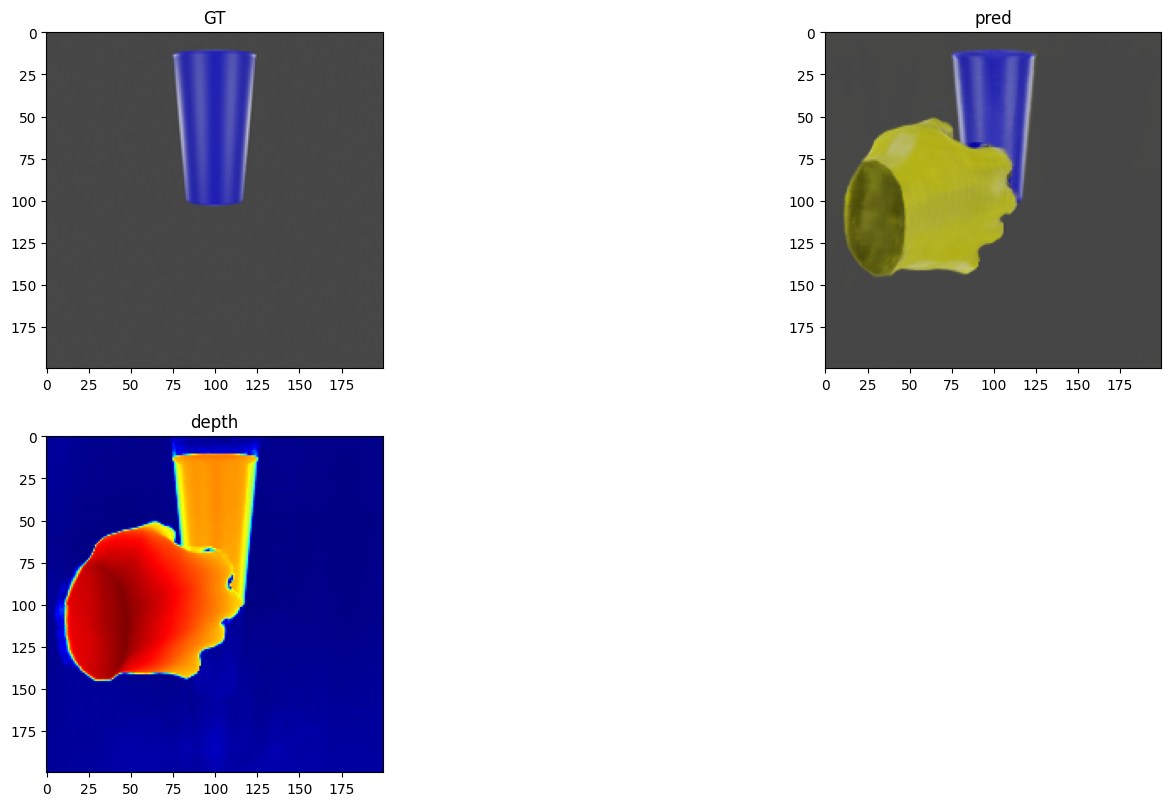

In [10]:
img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
alpha_pred = results['opacity_fine'].view(img_wh[1], img_wh[0]).cpu().numpy()
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])
print('PSNR', metrics.psnr(img_gt, img_pred).item())

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(221)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(222)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(223)
plt.title('depth')
plt.imshow(visualize_depth(depth_pred).permute(1,2,0))
plt.show()